In [34]:
import numpy as np
def jump(x, alpha=0, beta=0.5):
    one = lambda x: 1
    return np.where((x<beta) & (x>=alpha), one(x), 0.)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

###Timestepping methods###
def picard(X, nx, nt, Tfinal, mu, theta, form):
    """theta picard method"""
    ### Parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ### warnings ###
    ### Initialise structure ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    if form == "non conservative":
        if theta >0:
            for i in range(0,nt-1):###time stepping###
        
                for j in range(0,nx): ### create vector on RHS###
                    beta[j] = X[j]\
                    - C*(1-theta)*X[j]*(X[(j+1)%nx] - X[(j-1)%nx])\
                    + (D)*(1-theta)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])
        
                for p in range(0,nx): ### Create Matrix on LHS ###
                    A[p,(p+1)%nx] =  theta*C*X[p] - theta*D # b 
                    A[p,(p-1)%nx] = -theta*C*X[p] - theta*D  #c  
                    A[p,p] = 1 + 2*theta*D
            
                X[:] = scipy.linalg.solve(A, beta)### Solving for next timestep ###
        if theta == 0: ## to avoid inverting a identity matrix pointlessly.
            for i in range(0,nt-1):###time stepping###
                for j in range(0,nx): ### create vector on RHS###
                    beta[j] = X[j]\
                    - C*(1-theta)*X[j]*(X[(j+1)%nx] - X[(j-1)%nx])\
                    + (D)*(1-theta)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])

                X[:] = beta ### Solving for next timestep ###
    ###
    if form == "conservative":
        if theta >0:
            for i in range(0,nt-1):###time stepping###
        
                for j in range(0,nx): ### create vector on RHS###
                    beta[j] = X[j]\
                    - C*0.5*(1)*(X[(j+1)%nx]**2 - X[(j-1)%nx]**2)\
                    + (D)*(1)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])
           
                for p in range(0,nx): ### Create Matrix on LHS ###
                    A[p,(p+1)%nx] =  0.5*theta*C*X[p] - theta*D # b 
                    A[p,(p-1)%nx] = -0.5*theta*C*X[p] - theta*D  #c  
                    A[p,p] = 1 + 2*theta*D + C*theta*0.5*(X[(p+1)%nx] - X[(p-1)%nx])
        
                X[:] = scipy.linalg.solve(A, beta)### Solving for next timestep ###
        ###
        if theta == 0: ## to avoid inverting a identity matrix pointlessly.
            for i in range(0,nt-1):###time stepping###
                for j in range(0,nx): ### create vector on RHS###
                    beta[j] = X[j]\
                    - C*0.5*(1)*(X[(j+1)%nx]**2 - X[(j-1)%nx]**2)\
                    + (D)*(1)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])
    
                X[:] = beta ### Solving for next timestep ###        
 
    return X

   
def newton(X, nx, nt, Tfinal, mu, theta, form):

    ### derived parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ##Creation of newton method structure 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])
    if form == "non conservative":
        for i in range(0,nt-1):### time loop 
        
            for j in range(0,nx): 
                w[j] = X[j] ### first initialise w^0 = phi^n as initial guess###
                          ### this is the starting guess for newton method ###
        
            ### Construct the newton loop
            tol = 10**(-13)## extreeme accuracy can be imposed
            err  = 2*tol
            while (err>tol): ### until convergence ###
            
                ### Create beta^k_j ###
                for q in range(0,nx): 
                    beta[q] = X[q] - C*(1-theta)*X[q]*(X[(q+1)%nx] - X[(q-1)%nx]) + (D)*(1-theta)*(X[(q-1)%nx]-2*X[q]+X[(q+1)%nx]) \
                    -w[q] - C*theta*w[q]*(w[(q+1)%nx]-w[(q-1)%nx]) + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
                ##Create A^k_j ###
                A = np.zeros([nx,nx])
                for p in range(1,nx):
                    A[p-1,p] = ((theta*C*w[p])-(theta*D)) # b
                for p in range(0,nx-1):
                    A[p+1,p] = ((-theta*C*w[p+1])-(theta*D)) # c
                for p in range(0,nx):
                    A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
            
            
                ## solving for dw
                dw = scipy.linalg.solve(A, beta)
                err = np.linalg.norm(dw,2)
                ## improve the newton loop
                w = w + dw 
                ## we have w^k
            
    
        
            for j in range(0,nx): ##replace
                X[j] = w[j]
    if form == "conservative":
        for i in range(0,nt-1):### time loop 
            ## first initialise w^0 = phi^n
            for j in range(0,nx): 
                w[j] = X[j]

            ### Construct the newton loop
            tol = 10**(-13) ### accuracy can be imposed ###
            err  = 2*tol
            while (err>tol): ## eventually replace with while loop and stopping criterion

                ### Create beta^k ###
                for q in range(0,nx): 
                    beta[q] = X[q] - C*0.5*(1-theta)*(X[(q+1)%nx]**2 - X[(q-1)%nx]**2) \
                    + (D)*(1-theta)*(X[(q-1)%nx]-2*X[q]+X[(q+1)%nx]) \
                    -w[q] - C*0.5*theta*(w[(q+1)%nx]**2-w[(q-1)%nx]**2) \
                    + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
                ### Create A^k_j, tridiag ###
                A = np.zeros([nx,nx])
                for p in range(1,nx):
                    A[p-1,p] = ((theta*C*w[(p+1)%nx])-(theta*D)) # down zero across 1 = b
                for p in range(0,nx-1):
                    A[p+1,p] = ((-theta*C*w[(p-1)%nx])-(theta*D)) # down 1 acros 0 = c
                for p in range(0,nx):
                    A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
        
                ## solving for dw
                dw = scipy.linalg.solve(A, beta)
                err = np.linalg.norm(dw,2)
                ## improve the newton loop
                w = w + dw 
                ## we have w^k
            for j in range(0,nx):
                X[j] = w[j]

    return X 


    

In [36]:
import numpy as np
import math as math
import matplotlib.pyplot as plt


def SolveBurger(nx ,nt ,Tfinal ,mu, method, theta, form):
    """SolveBurger: 
    
SUMMARY:
    This function takes an "initial_condition" and solves
    the "conservative" or "non conservative" burgers equation 
    numerically for some later time "Tfinal".
                    
FLEXIBILITY:
    You can choose: the "method" used, the spatial 
    discretisation used "nx", the number of timesteps "nt",
    the viscosity term "mu", the implicitness of the scheme
    "theta"
                    
FORMS OF BURGERS EQUATION:
    Non Conservative form  -->    u_t + u(u_x) - mu u_{xx} = 0 
    Conservative form      -->    u_t + (u^2/2)_x - mu u_{xx} = 0 
      
Inputs:      
    nx      = number of space points
    nt      = number of time points 
    Tfinal  = the final time  
    mu      = the viscosity in the burgers equation 
    method  = "picard" SOLVES APPROXIMATION TO BURGERS EQUATION
              "newton" SOLVES EXACT BURGERS EQUATION
              "conservative_ftcs" SOLVES CONSERVATIVE FORM USING EXPLICIT METHOD
              "conservatice_newton" SOLVES CONSERVATIVE FORM USING NEWTONS METHOD
    theta   = 1 is implicit,
              0 is explicit,
              a in IR, You can put in other real values, 
                
Output:
    A vector representing the numerical solution 
                """
    
    ##**Creating the structure**## 
    X = np.zeros( [nx] )##**Each row contains a timestep**##
    x = np.linspace(0,1,nx)
    ### Initialisation of BC ###
    X[:] = jump(x, 0.1, 0.3)

    
### Timestepping the whole scheme 
    if method == "newton":
        newton(X, nx, nt, Tfinal, mu, theta, form)
    if method == "picard":
        picard(X, nx, nt, Tfinal, mu, theta, form)
    return X



In [46]:
def Plotting(X,nx):
    x = np.linspace(0,1,nx)
    y = X[:]
    plt.plot(x, y,linewidth=0.5)

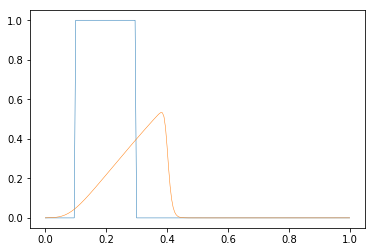

In [47]:
X = SolveBurger(201,15,0,0.001,"picard",1,"non conservative")
Plotting(X,201)
X = SolveBurger(201,15,0.5,0.001,"picard",1,"non conservative")
Plotting(X,201)

In [48]:
# analytical solution ## incomplete
### Do I need to compute against a analytical solution?
help(SolveBurger)

Help on function SolveBurger in module __main__:

SolveBurger(nx, nt, Tfinal, mu, method, theta, form)
    SolveBurger: 
        
    SUMMARY:
        This function takes an "initial_condition" and solves
        the "conservative" or "non conservative" burgers equation 
        numerically for some later time "Tfinal".
                        
    FLEXIBILITY:
        You can choose: the "method" used, the spatial 
        discretisation used "nx", the number of timesteps "nt",
        the viscosity term "mu", the implicitness of the scheme
        "theta"
                        
    FORMS OF BURGERS EQUATION:
        Non Conservative form  -->    u_t + u(u_x) - mu u_{xx} = 0 
        Conservative form      -->    u_t + (u^2/2)_x - mu u_{xx} = 0 
          
    Inputs:      
        nx      = number of space points
        nt      = number of time points 
        Tfinal  = the final time  
        mu      = the viscosity in the burgers equation 
        method  = "picard" SOLVES APPR

picards linearisation is inaccurate for large time steps
implicit allows for big timesteps, but this will make picards approximation inaccurate


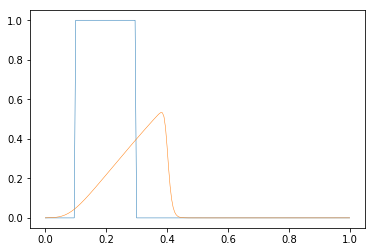

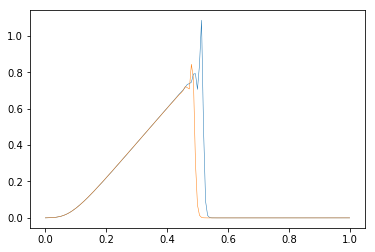

In [49]:
X = SolveBurger(201,15,0,0.001,"picard",1,"non conservative")
Plotting(X,201)
X = SolveBurger(201,15,0.5,0.001,"picard",1,"non conservative")
Plotting(X,201)
print( "picards linearisation is inaccurate for large time steps" )
print( "implicit allows for big timesteps, but this will make picards approximation inaccurate")
## the scheme for theta=1 converges even for few large timesteps.
## however the equation solved is inaccurate, it isnt the correct eqaution.

plt.figure(2)
X = SolveBurger(151,501,0.5,0.001,"picard",0.5,"non conservative") 
Plotting(X,151)
plt.figure(2)
X = SolveBurger(151,201,0.5,0.001,"picard",1,"non conservative") 
Plotting(X,151)

here we get that newton is picards is ftcs for theta = 0


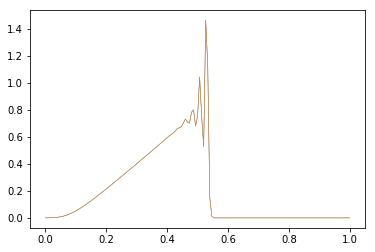

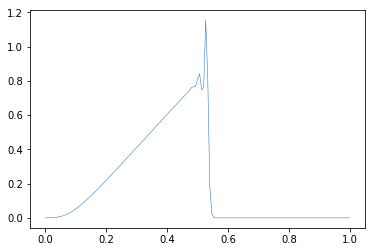

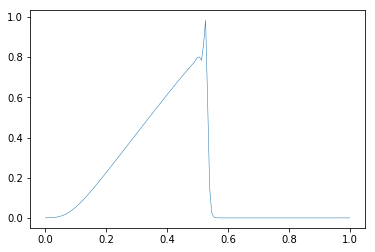

In [50]:

#consistency of code:
plt.figure(0)
X = SolveBurger(151,151,0.5,0.001,"newton",0,"non conservative")
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"picard",0,"non conservative") 
Plotting(X,151)
print("here we get that newton is picards is ftcs for theta = 0")

X = SolveBurger(151,151,0.5,0.001,"newton",0.5,"non conservative")
plt.figure(1)
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"newton",1,"non conservative")
plt.figure(2)
Plotting(X,151)

##look even newton has theta stability conditions?
## there is a timestep restriction independent of the timestep condition.

Here is a noteworthy case, the conservative form wont converge. why is the timestepping condition stricter than the non conservative form


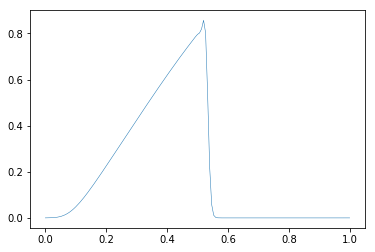

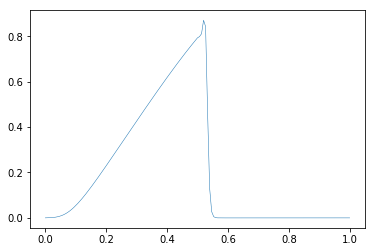

In [51]:
X = SolveBurger(151,101,0.5,0.001,"newton",1,"conservative")
Plotting(X,151)
plt.figure(0)
X = SolveBurger(151,81,0.5,0.001,"newton",1,"non conservative")
Plotting(X,151)
print("Here is a noteworthy case, the conservative form wont converge. \
why is the timestepping condition stricter than the non conservative form")


consistency of code for theta = 0
it appears implicitness adds diffusivity as before, but not 


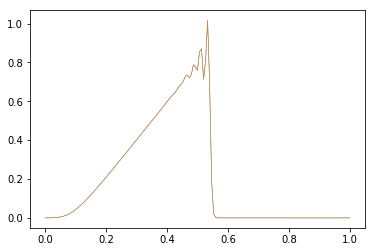

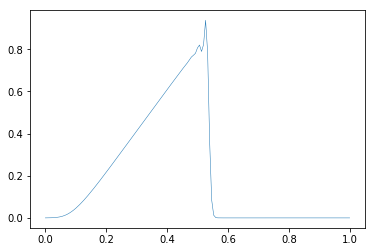

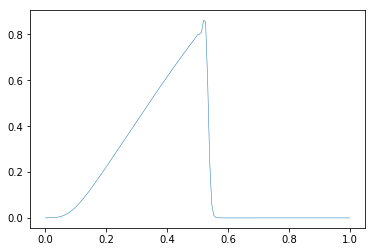

In [53]:
plt.figure(0)
X = SolveBurger(151,151,0.5,0.001,"newton",0,"conservative") 
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"picard",0,"conservative") 
Plotting(X,151)
print("consistency of code for theta = 0")
plt.figure(1)
X = SolveBurger(151,151,0.5,0.001,"newton",0.5,"conservative") 
Plotting(X,151)
plt.figure(2)
X = SolveBurger(151,151,0.5,0.001,"newton",1,"conservative")
Plotting(X,151)
print("it appears implicitness adds diffusivity as before, but not ")


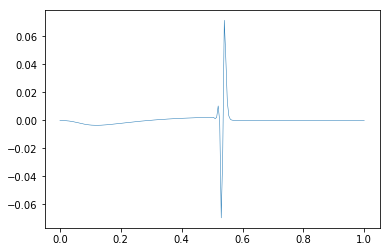

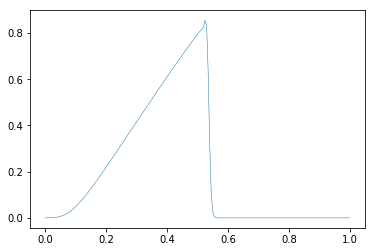

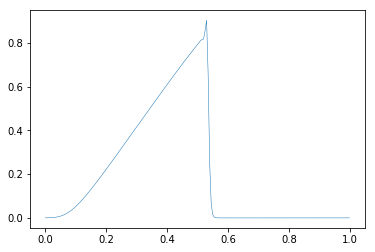

In [54]:
X = SolveBurger(201,201,0.5,0.001,"newton",1,"conservative")
Y = SolveBurger(201,201,0.5,0.001,"newton",1,"non conservative")
C = X-Y
plt.figure(1)
Plotting(C,201)
plt.figure(2)
Plotting(X,201)
plt.figure(3)
Plotting(Y,201)

In [ ]:
#•Stability analysis for theta = 0 cases remembering whether vonn neuman annalisis works

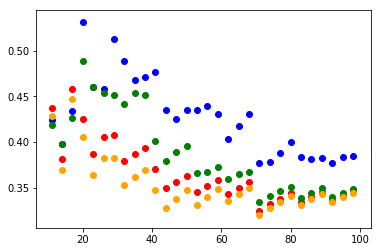

In [72]:

for w in range(30):
 
    nx = 3*w+11
    nt = 151
    AA = SolveBurger(nx,nt,0.5,0.001,"picard",0,"conservative")
    yy = np.linalg.norm(AA,2)/nx**0.5
    plt.scatter(nx,yy,color='red')
    BB = SolveBurger(nx,nt,0.5,0.001,"picard",0,"non conservative")
    yy = np.linalg.norm(BB,2)/nx**0.5
    plt.scatter(nx,yy,color='blue')
    BB = SolveBurger(nx,nt,0.5,0.001,"newton",1,"non conservative")
    yy = np.linalg.norm(BB,2)/nx**0.5
    plt.scatter(nx,yy,color='green')
    BB = SolveBurger(nx,nt,0.5,0.001,"newton",1,"conservative")
    yy = np.linalg.norm(BB,2)/nx**0.5
    plt.scatter(nx,yy,color='orange')

In [ ]:

A = np.zeros([3,3])
A[0,1] = 1
print(A)